# Plots

This note book consists of
- functions which should used in every plot to ensure the same style in every plot (good for readers)
- two cells for every experiment file
    - first cell sets/resets data according to experiments files
    - second cell reads data and crates plots

In [1]:
from os import listdir
from os.path import isfile, join
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import pprint
import os

### config

In [2]:
results_directory = "../data/results/"

### load data
load all result files, individual data will be selected later

In [3]:
results_meta = {}

# get files and ids
for name in listdir(results_directory):
    path = join(results_directory, name)
    if isfile(path):
        id = name[:-7]
        results_meta[id] = {"result_pickle":path}

# add data
for key in results_meta:
    with open(results_meta[key]["result_pickle"], 'rb') as handle:
        results_meta[key]["data"] = pickle.load(handle)

# print info
for key in results_meta: 
    print(
        key, " ",
        results_meta[key]["result_pickle"], " ",
        type(results_meta[key]["data"]), " ",
        len(results_meta[key]["data"])
    )  

twitter_diff_dist   ../data/results/twitter_diff_dist.pickle   <class 'tuple'>   3
twitter_drift_induction   ../data/results/twitter_drift_induction.pickle   <class 'dict'>   3
amazon_diff_classes   ../data/results/amazon_diff_classes.pickle   <class 'dict'>   3
amazon_same_dist   ../data/results/amazon_same_dist.pickle   <class 'dict'>   3
twitter_same_dist   ../data/results/twitter_same_dist.pickle   <class 'dict'>   3
twitter_diff_classes   ../data/results/twitter_diff_classes.pickle   <class 'dict'>   3
amazon_drift_induction   ../data/results/amazon_drift_induction.pickle   <class 'dict'>   3


### plot functions
functions to ensure same layout in every plot

In [4]:
def get_label(detector_name):
    mappings = {
        "cdbd" : "CDBD",
        "csdd" : "Cosine Similarity",
        "kts" : "KTS/MMD", # "Kernel Two Sample",
        "aks" : "KS",
        "lsdd" : "LSDD",
        "ammd" : "MMD",
    }
    if(detector_name in mappings):
        return mappings[detector_name]
    else:
        print("Unknown detector label:", detector_name)
        return detector_name


def get_plot_config(detector_label, config={}):
    # detector_label: See get_label(detector_name)
    # config:         See https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.plot.html
    
    # Often similar: Kernel Two Sample, LSDD, MMD
    # https://matplotlib.org/stable/tutorials/colors/colors.html
    # 'tab:blue''tab:orange''tab:green''tab:red''tab:purple''tab:brown''tab:pink''tab:gray''tab:olive''tab:cyan'
    # '-' or 'solid' / '--' or 'dashed' / '-.' or 'dashdot' / ':' or 'dotted'
    linewidth = 1.6 #1.2
    linewidth_thicker = 2 #1.6
    linewidth_thick = 2.4 #2
    if(detector_label == "CDBD"):
        config.update(color='tab:green',  linestyle='-.',  linewidth=linewidth_thicker)  # formerly color='tab:green',  linestyle='-',  linewidth=linewidth
    elif(detector_label == "Cosine Similarity"):
        config.update(color='tab:gray',   linestyle=':',  linewidth=linewidth_thick)
    elif(detector_label == "KTS/MMD"): # CLOSE ONE  # formerly "Kernel Two Sample"
        config.update(color='tab:orange',    linestyle='-',  linewidth=linewidth_thicker)  # formerly color='tab:red',    linestyle='-',  linewidth=linewidth_thicker
    elif(detector_label == "KS"):
        config.update(color='tab:purple', linestyle='--', linewidth=linewidth)
    elif(detector_label == "LSDD"): # CLOSE ONE
        config.update(color='tab:blue', linestyle=':', linewidth=linewidth_thick)  # formerly color='tab:orange', linestyle='-.', linewidth=linewidth_thicker
    elif(detector_label == "MMD"): # CLOSE ONE
        config.update(color='tab:blue',   linestyle='--', linewidth=linewidth_thicker)
    else: # Not used in default cases
        config.update(color='tab:olive',  linestyle='-',  linewidth=linewidth)
    return config


def plot_injection(plot_data, legend_loc="upper center", ylim_top=1.03, pdf_filename=None, xlabel=True, ylabel=True):
    # plot_data:  dict[detector_id] = list of floats
    # legend_loc: location of legend
    #             https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
    # ylim_top:   max y value to adjust different figutes
    #             https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.ylim.html
    
    # ensure complete data
    for detector in plot_data:
        if(len(plot_data[detector]) != 21):
            raise ValueError(detector, len(plot_data[detector]))
    
    # default percentages
    target_percentages = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    target_percentages.insert(0, 0)
    x_values = np.divide(target_percentages, 2)
    
    # sort by label for legend
    labels_to_detectors = {}
    for detector in plot_data:
        labels_to_detectors[get_label(detector)] = detector
    
    # add lines
    fig, ax = plt.subplots()
    plt.axhline(y=0.05, color='tab:gray', linestyle='-')
    for label in sorted(labels_to_detectors):
        detector = labels_to_detectors[label]
        ax.plot(x_values, plot_data[detector], label=label, **get_plot_config(label, {}))
    
    # plot config
    ax.grid(color='#dddddd')
    ax.set_xlim([0, 0.5])
    ax.set_ylim([-0.03, ylim_top])

    if(xlabel):
        plt.xlabel('Percentage of injected negative words', fontsize="large")
        #plt.xticks(ticks=x_values, labels=x_values, rotation=60) # Alternative to AutoMinorLocator
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))           # Alternative to set xticks
        
    if(ylabel):
        plt.ylabel('p-value', fontsize="large")
    else:
        # see https://stackoverflow.com/a/12998531
        # see https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.tick_params.html
        plt.tick_params(
            axis='y',
            which='both',
            left=False,
            right=False,
            labelleft=False)
        
    plt.legend(loc=legend_loc, fontsize="large") # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html

    # save
    if pdf_filename is not None:
        fig.tight_layout()
        print("Saving", pdf_filename)
        fig.savefig(pdf_filename, format='pdf')

    plt.show()

# twitter_drift_induction

In [5]:
# set config from notebook
permutations = 10
modes = ['bert_768', 'bow_50', 'bow_768']
target_percentages = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
detectors = {
    'csdd': 'CosineSimilarityDriftDetector()',
    'kts' : 'KernelTwoSampleDriftDetector()',
    'aks' : 'AlibiKSDetector()',
    'ammd': 'AlibiMMDDetector()',
    'lsdd': 'AlibiLSDDDetector()',
    'cdbd': 'CDBDDetector()',
}
result_pickle = results_meta["twitter_drift_induction"]["result_pickle"]
try:
    del results
except NameError:
    pass

Loading result pickle:  ../data/results/twitter_drift_induction.pickle
bert_768
Saving ../figures/by_dataset/twitter_bert_768_drift_induction_all.pdf


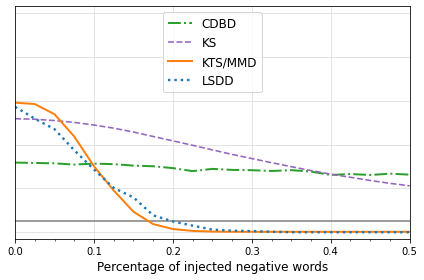

bow_50
Saving ../figures/by_dataset/twitter_bow_50_drift_induction_all.pdf


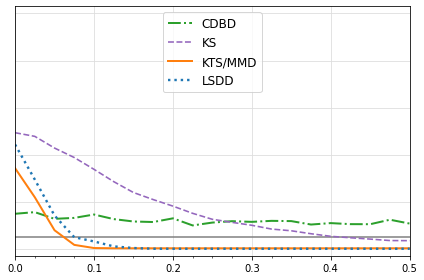

bow_768
Saving ../figures/by_dataset/twitter_bow_768_drift_induction_all.pdf


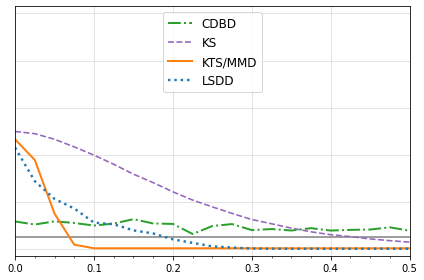

In [6]:
# load results if not existing
try:
    results
except NameError:
    print('Loading result pickle: ', result_pickle)
    with open(result_pickle, 'rb') as handle:
        results = pickle.load(handle)    

# plot
for mode in modes:
    print(mode)
    plot_data = {}
       
    for detector in detectors:
        
        if(detector == "csdd" or detector == "ammd"): # Remove CosSim and MMD
            continue
        
        plot_data[detector] = []
        for n in range(len(results[mode][detector]['predictions'][0])):
            nth_entries = [results[mode][detector]['predictions'][i][n] for i in range(permutations)]
            plot_data[detector].append(np.mean(nth_entries))

    xlabel = False
    if(mode == "bert_768"):
        xlabel = True
    plot_injection(plot_data, pdf_filename='../figures/by_dataset/twitter_' + mode + '_drift_induction_all.pdf', xlabel=xlabel, ylabel=False)

# amazon_drift_induction.ipynb

In [7]:
# set config from notebook
permutations = 10
modes = ['bert_768', 'bow_50', 'bow_768']
target_percentages = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
detectors = {
    'csdd': "",
    'kts' : "",
    'aks' : "",
    'ammd': "",
    'lsdd': "",
    'cdbd': "",
}
result_pickle = results_meta["amazon_drift_induction"]["result_pickle"]
try:
    del results
except NameError:
    pass

Loading result pickle:  ../data/results/amazon_drift_induction.pickle
bert_768
Saving ../figures/by_dataset/amazon_bert_768_drift_induction_all.pdf


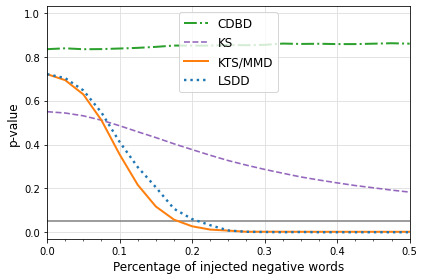

bow_50
Saving ../figures/by_dataset/amazon_bow_50_drift_induction_all.pdf


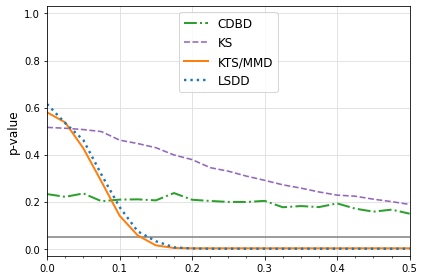

bow_768
Saving ../figures/by_dataset/amazon_bow_768_drift_induction_all.pdf


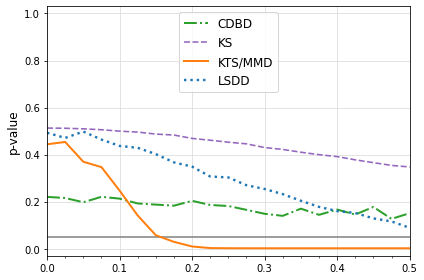

In [8]:
# load results if not existing
try:
    results
except NameError:
    print('Loading result pickle: ', result_pickle)
    with open(result_pickle, 'rb') as handle:
        results = pickle.load(handle)    

# plot
for mode in modes:
    print(mode)
    plot_data = {}
       
    for detector in detectors:
        
        if(detector == "csdd" or detector == "ammd"): # Remove CosSim and MMD
            continue
            
        plot_data[detector] = []
        for n in range(len(results[mode][detector]['predictions'][0])):
            nth_entries = [results[mode][detector]['predictions'][i][n] for i in range(permutations)]
            plot_data[detector].append(np.mean(nth_entries))
            
    xlabel = False
    if(mode == "bert_768"):
        xlabel = True
    plot_injection(plot_data, pdf_filename='../figures/by_dataset/amazon_' + mode + '_drift_induction_all.pdf', xlabel=xlabel)